# MPSC Train
<hr >

In this notebook we will train models, and test some ideas

## Table Of Content
<hr >

1. [Introduction](#Introduction)
2. [Imports and Load](#Imports-and-Load)

## Introduction
<hr >

> The flow for our taraining process will be as in chart below

>![](./img/flow_diagram.png)

In [1]:
import warnings; warnings.filterwarnings('ignore')
import sys
import joblib
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers, Model

In [2]:
COLAB = "google.colab" in sys.modules
if COLAB:
    print('we are using colab env\n')
    from google.colab import drive
    drive._mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/mpsc/data/' # path to our data on Colab
    MODELS_PATH = '/content/drive/MyDrive/mpsc/models/'
else:
    DATA_PATH = '../data/' # path to our data on local machine
    MODELS_PATH = '../models/'
    
TARGET = 'price'
SEED = 123
MAX_NUM_WORDS_NAME = 40000
MAX_NUM_WORDS_DESC = 80000
MAX_SEQ_LEN_NAME = 20
MAX_SEQ_LEN_DESC = 64

we are using colab env

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    
class ItemSelector(Transformer):
    def __init__(self, field, fillna_value=None, fillna_from_field=None):
        self.field = field
        self.fillna_value = fillna_value
        self.fillna_from_field = fillna_from_field
    
    def transform(self, df):
        series = df[self.field]
        if self.fillna_from_field:
            series = series.fillna(df[self.fillna_from_field])
            
        if self.fillna_value:
            series = series.fillna(self.fillna_value)
        
        return series
    
    
class SubCategorySpliter(Transformer):
    def __init__(self, delimiter='/', maxsplit=2, nth_split=0):
        self.delimiter = delimiter
        self.nth_split = nth_split
        self.maxsplit = maxsplit
        
    def transform(self, series):
        return series.apply(lambda x: x.split(self.delimiter, self.maxsplit)[self.nth_split])
    
    
class SeriesToArray(Transformer):
    def __init__(self, shape=(-1, 1)):
        self.shape = shape
        
    def transform(self, series):
        return series.values.reshape(self.shape)
    
    
class TextToSeq(Transformer):
    def __init__(
        self,
        num_words=None,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        maxlen=100,
        sparse=True,
        dtype=np.uint32
    ):
        self.num_words = num_words
        self.filters = filters
        self.lower = lower
        self.maxlen = maxlen
        self.sparse = sparse
        self.dtype = dtype
        
    def fit(self, series, y=None):
        self.tokenizer = Tokenizer(num_words=self.num_words, filters=self.filters, lower=self.lower)
        self.tokenizer.fit_on_texts(series)
        
        return self
        
    def transform(self, series):
        seqs = self.tokenizer.texts_to_sequences(series)
        pad_seqs = pad_sequences(seqs, maxlen=self.maxlen, dtype=self.dtype)
        if self.sparse:
            pad_seqs = csr_matrix(pad_seqs)
        
        return pad_seqs
    
    
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, pipes, target, batch_size=1024, train=True, shuffle=True):
        self.df = df
        self.pipes = pipes
        self.target = target
        self.train = train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df)/ self.batch_size))
    
    def __getitem__(self, idx):
        sub_idxs = self.idxs[idx*self.batch_size:(idx+1)*self.batch_size]
        sub_df = self.df.iloc[sub_idxs]
        X, y = self.__data_generation(sub_df)
        
        return X, y

    def on_epoch_end(self):
        self.idxs = np.arange(len(self.df))
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, sub_df):
        X = [pipe.transform(sub_df) for pipe in self.pipes]
        if self.train:
            return X, np.log1p(sub_df[self.target].values)
        
        return X

In [4]:
df = pd.read_csv(DATA_PATH+ 'mpsc_train.csv')
df_train, df_valid = train_test_split(df, random_state=SEED, train_size=0.8)

pipe_name = Pipeline([
    ('selector', ItemSelector(field='name', fillna_from_field='item_description', fillna_value='')),
    ('seq', TextToSeq(num_words=MAX_NUM_WORDS_NAME, maxlen=MAX_SEQ_LEN_NAME, sparse=False)),
]).fit(df_train)

pipe_desc = Pipeline([
    ('selector', ItemSelector(field='item_description', fillna_from_field='name', fillna_value='No description yet')),
    ('seq', TextToSeq(num_words=MAX_NUM_WORDS_DESC, maxlen=MAX_SEQ_LEN_DESC, sparse=False)),
]).fit(df_train)

pipe_othe = FeatureUnion([
    ('category_name', Pipeline([
        ('selector', ItemSelector(field='category_name', fillna_value='Other/Other/Other')),
        ('cats', FeatureUnion([
            (f'sub_{i}', Pipeline([
                ('sub', SubCategorySpliter(delimiter='/', maxsplit=2, nth_split=i)),
                ('sta', SeriesToArray()),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.uint8)),
            ])) for i in range(3)
            ])),
    ])),
    ('item_condition_id', Pipeline([
        ('selector', ItemSelector(field='item_condition_id')),
        ('sta', SeriesToArray()),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.uint8))
    ])),
    ('brand_name', Pipeline([
        ('selector', ItemSelector(field='brand_name', fillna_value='Other')),
        ('sta', SeriesToArray()),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.uint8))
    ])),
    ('shipping', Pipeline([
        ('selector', ItemSelector(field='shipping')),
        ('sta', SeriesToArray()),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.uint8))
    ])),
]).fit(df_train)

pipes = [pipe_name, pipe_desc, pipe_othe]

dg_train = DataGenerator(df=df_train, pipes=pipes, target=TARGET, batch_size=1024)
dg_valid = DataGenerator(df=df_valid, pipes=pipes, target=TARGET, batch_size=1024, shuffle=False)

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    
class CustomOutputLayer(layers.Layer):
    def __init__(self, min_val, max_val, **kwargs):
        super(CustomOutputLayer, self).__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
        
    def call(self, inputs):
        outputs = tf.sigmoid(inputs)* (self.max_val- self.min_val)+ self.min_val
        output = tf.reduce_mean(outputs, axis=1, keepdims=True)
        
        return output
        
def get_model(seq_1_len, seq_2_len, feats_len, seq_1_max, seq_2_max, out_min_val, out_max_val, use_cuslayer=True):
    seq_1 = layers.Input((seq_1_len,))
    s_1 = layers.Embedding(seq_1_max, 128)(seq_1)
    s_1 = TransformerBlock(128, 4, 128)(s_1)
    s_1 = layers.GlobalAvgPool1D()(s_1)
    
    seq_2 = layers.Input((seq_2_len,))
    s_2 = layers.Embedding(seq_2_max, 128)(seq_2)
    s_2 = TransformerBlock(128, 4, 128)(s_2)
    s_2 = layers.GlobalAvgPool1D()(s_2)
    
    rest_ = layers.Input((feats_len,))
    
    vec = layers.Concatenate(axis=1)([s_1, s_2, layers.Dense(64)(rest_)])
    vec = layers.Dense(64)(vec)
    if use_cuslayer:
        out = CustomOutputLayer(out_min_val, out_max_val)(vec)
    else:
        out = layers.Dense(1)(vec)
        
    model = Model(inputs=[seq_1, seq_2, rest_], outputs=[out])
    
    return model

In [6]:
model_1 = get_model(pipe_name.transform(df_train.iloc[0:1]).shape[1],
                  pipe_desc.transform(df_train.iloc[0:1]).shape[1],
                  pipe_othe.transform(df_train.iloc[0:1]).shape[1],
                  MAX_NUM_WORDS_NAME,
                  MAX_NUM_WORDS_DESC,
                  0,
                  8
                 )
model_1.summary()
model_1.compile(loss='mse', optimizer=keras.optimizers.Adam(beta_1=0.9, beta_2=0.9))
history_1 = model_1.fit(dg_train, validation_data=dg_valid, epochs=4, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 128)      5120000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 64, 128)      10240000    ['input_2[0][0]']                
                                                                                              

In [7]:
model_2 = get_model(pipe_name.transform(df_train.iloc[0:1]).shape[1],
                  pipe_desc.transform(df_train.iloc[0:1]).shape[1],
                  pipe_othe.transform(df_train.iloc[0:1]).shape[1],
                  MAX_NUM_WORDS_NAME,
                  MAX_NUM_WORDS_DESC,
                  0,
                  8,
                  use_cuslayer=False
                 )
model_2.summary()
model_2.compile(loss='mse', optimizer=keras.optimizers.Adam(beta_1=0.9, beta_2=0.9))
history_2 = model_2.fit(dg_train, validation_data=dg_valid, epochs=4, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 20, 128)      5120000     ['input_4[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 64, 128)      10240000    ['input_5[0][0]']                
                                                                                            

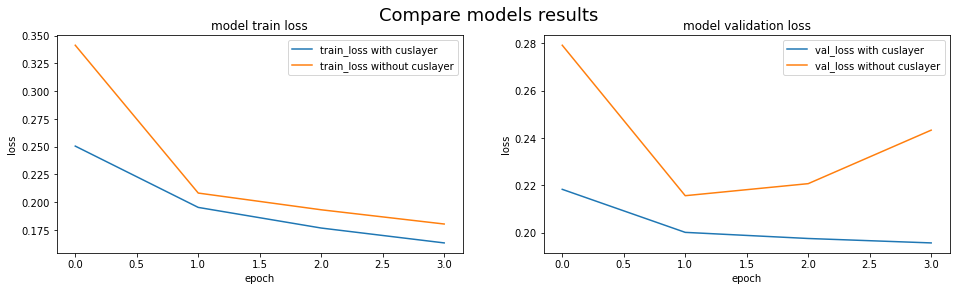

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.suptitle('Compare models results', fontsize=18)
ax = plt.subplot(1, 2, 1)
ax.set_title(f'model train loss', fontsize=16)
plt.plot(history_1.history['loss'])
plt.plot(history_2.history['loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss with cuslayer', 'train_loss without cuslayer'], loc='upper right')
ax = plt.subplot(1, 2, 2)
ax.set_title(f'model validation loss', fontsize=16)
plt.plot(history_1.history['val_loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss with cuslayer', 'val_loss without cuslayer'], loc='upper right')
plt.show()

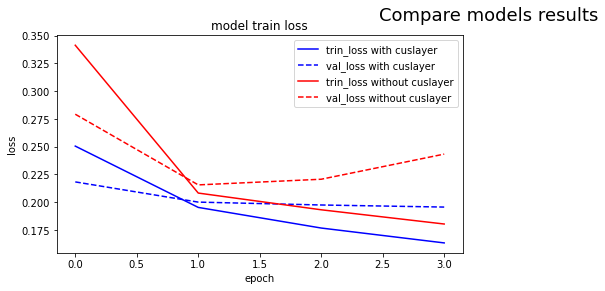

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.suptitle('Compare models results', fontsize=18)
ax = plt.subplot(1, 2, 1)
ax.set_title(f'model train loss', fontsize=16)
plt.plot(history_1.history['loss'], 'b')
plt.plot(history_1.history['val_loss'], 'b--')
plt.plot(history_2.history['loss'], 'r')
plt.plot(history_2.history['val_loss'], 'r--')
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['trin_loss with cuslayer', 'val_loss with cuslayer', 'trin_loss without cuslayer', 'val_loss without cuslayer'], loc='upper right')

## Save models

In [10]:
joblib.dump(pipes, MODELS_PATH+ 'pipes.pkl')
model_1.save_weights(MODELS_PATH+ 'model_1_weights.hdf')
model_2.save_weights(MODELS_PATH+ 'model_2_weights.hdf')